# Crop Recommendation and Yield Prediction - AI Model

## Project Goal
Use machine learning to:
- Recommend the most suitable crop based on N, P, K values, temperature, humidity, pH, and rainfall.
- Predict the expected yield (in tons per hectare) for the recommended crop using historical weather and crop data.

## Dataset 1: Crop Recommendation
Columns: N, P, K, temperature, humidity, ph, rainfall, label (crop name)

## Dataset 2: Crop Yield Prediction
Columns: state, district, crop, year, season, rainfall, temperature, yield (tons/hectare)

## Steps:
1. Load and clean both datasets.
2. Perform EDA:
   - Show class distribution of crops.
   - Correlation matrix.
   - Average yield per crop/season.
3. Train ML models:
   - For classification: RandomForestClassifier for crop recommendation.
   - For regression: RandomForestRegressor or XGBoost for yield prediction.
4. Evaluate models using accuracy and R² score.
5. Save trained models using joblib for deployment in the app.

In [9]:
# Import required libraries and load datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
# Load datasets
crop_df = pd.read_csv('../data/crop_recommendation.csv')
yield_df = pd.read_csv('../data/weather_yield_data.csv')
 
print('Crop Recommendation Data Shape:', crop_df.shape)
print('Yield Prediction Data Shape:', yield_df.shape)
crop_df.head()

Crop Recommendation Data Shape: (20, 8)
Yield Prediction Data Shape: (20, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.5,80.0,6.5,200.0,rice
1,85,58,41,21.0,82.0,6.7,210.0,rice
2,60,55,44,23.0,60.0,7.0,150.0,maize
3,55,40,38,22.5,65.0,6.8,140.0,maize
4,40,35,30,25.0,55.0,6.2,120.0,wheat


In [10]:
# Data Cleaning: Handle missing values and show info
print('Missing values in crop_df:')
print(crop_df.isnull().sum())
print('\nMissing values in yield_df:')
print(yield_df.isnull().sum())
 
# Fill missing values if any (example: fill with median for numeric, mode for categorical)
crop_df = crop_df.fillna(crop_df.median(numeric_only=True))
for col in crop_df.select_dtypes(include=['object']).columns:
    crop_df[col] = crop_df[col].fillna(crop_df[col].mode()[0])
 
yield_df = yield_df.fillna(yield_df.median(numeric_only=True))
for col in yield_df.select_dtypes(include=['object']).columns:
    yield_df[col] = yield_df[col].fillna(yield_df[col].mode()[0])
 
print('\nAfter cleaning:')
print('Missing values in crop_df:', crop_df.isnull().sum().sum())
print('Missing values in yield_df:', yield_df.isnull().sum().sum())

Missing values in crop_df:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Missing values in yield_df:
state          0
district       0
crop           0
year           0
season         0
rainfall       0
temperature    0
yield          0
dtype: int64

After cleaning:
Missing values in crop_df: 0
Missing values in yield_df: 0


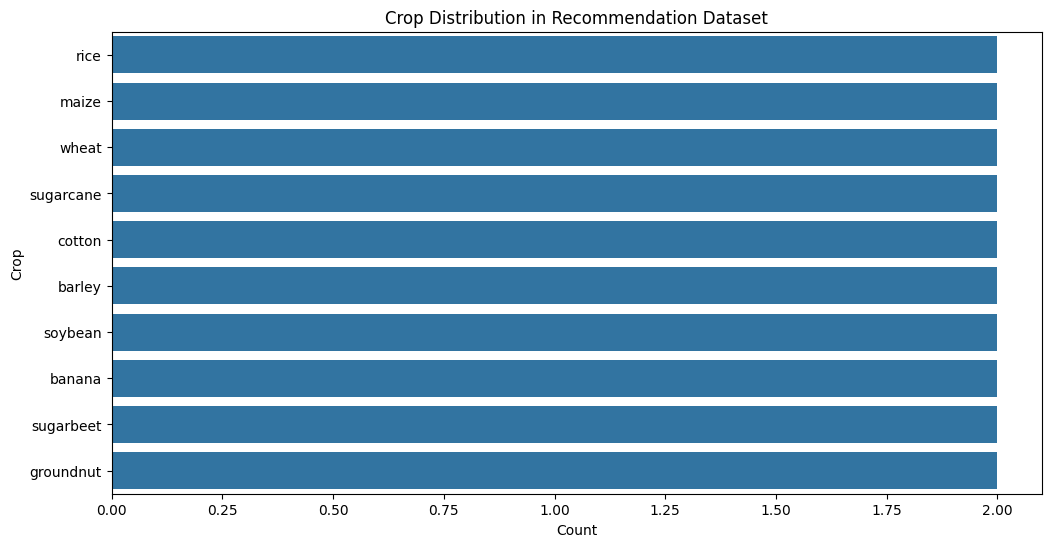

Crop counts:
label
rice         2
maize        2
wheat        2
sugarcane    2
cotton       2
barley       2
soybean      2
banana       2
sugarbeet    2
groundnut    2
Name: count, dtype: int64


In [11]:
# EDA: Class distribution of crops
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.countplot(y=crop_df['label'], order=crop_df['label'].value_counts().index)
plt.title('Crop Distribution in Recommendation Dataset')
plt.xlabel('Count')
plt.ylabel('Crop')
plt.show()
 
print('Crop counts:')
print(crop_df['label'].value_counts())

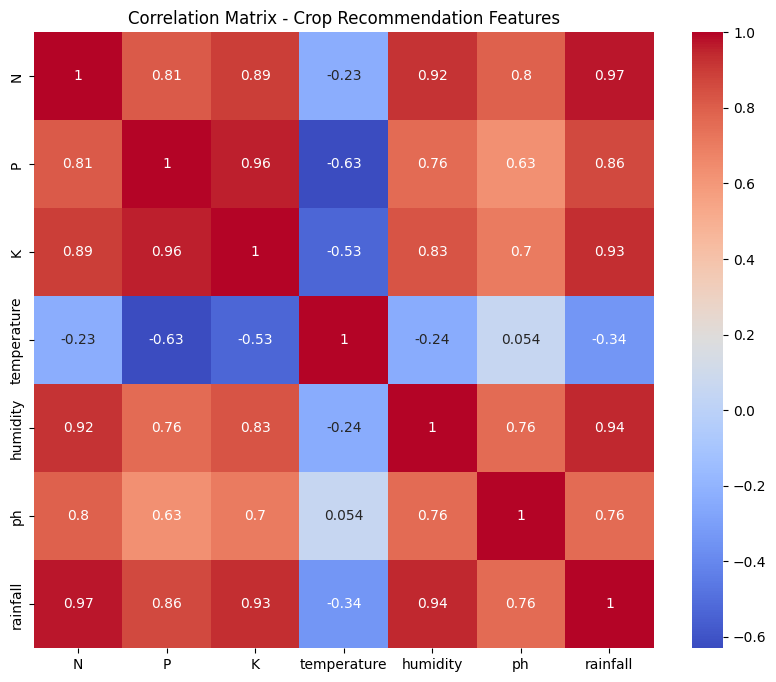

In [12]:
# EDA: Correlation matrix for crop recommendation dataset
plt.figure(figsize=(10,8))
sns.heatmap(crop_df.drop('label', axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Crop Recommendation Features')
plt.show()

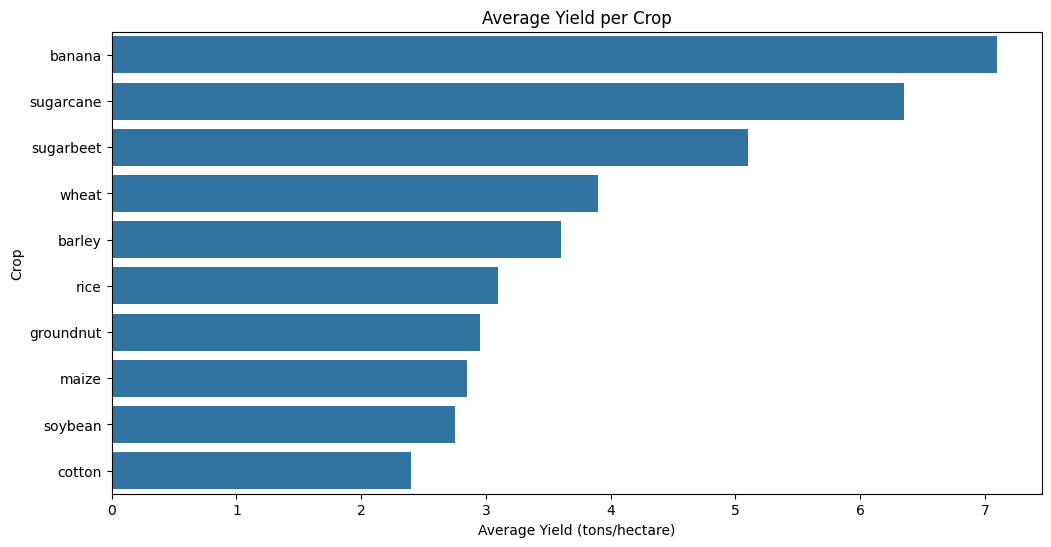

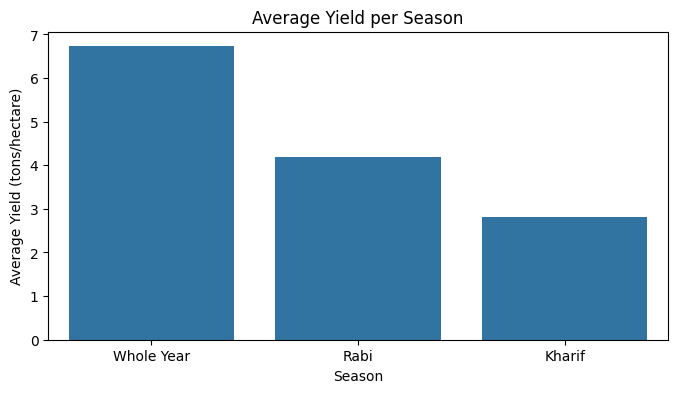

In [13]:
# EDA: Average yield per crop and per season
avg_yield_crop = yield_df.groupby('crop')['yield'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=avg_yield_crop.values, y=avg_yield_crop.index)
plt.title('Average Yield per Crop')
plt.xlabel('Average Yield (tons/hectare)')
plt.ylabel('Crop')
plt.show()
 
avg_yield_season = yield_df.groupby('season')['yield'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=avg_yield_season.index, y=avg_yield_season.values)
plt.title('Average Yield per Season')
plt.ylabel('Average Yield (tons/hectare)')
plt.xlabel('Season')
plt.show()

In [6]:
# Encode categorical variables and split datasets for model training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
 
# For crop recommendation (classification)
X_crop = crop_df.drop('label', axis=1)
y_crop = crop_df['label']
le_crop = LabelEncoder()
y_crop_encoded = le_crop.fit_transform(y_crop)
X_crop_train, X_crop_test, y_crop_train, y_crop_test = train_test_split(X_crop, y_crop_encoded, test_size=0.2, random_state=42)
 
# For yield prediction (regression)
yield_df_encoded = yield_df.copy()
for col in ['state', 'district', 'crop', 'season']:
    yield_df_encoded[col] = LabelEncoder().fit_transform(yield_df_encoded[col])
X_yield = yield_df_encoded[['rainfall', 'temperature', 'crop', 'season', 'year']]
y_yield = yield_df_encoded['yield']
X_yield_train, X_yield_test, y_yield_train, y_yield_test = train_test_split(X_yield, y_yield, test_size=0.2, random_state=42)

In [7]:
# Train RandomForestClassifier for crop recommendation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import numpy as np
 
clf_crop = RandomForestClassifier(n_estimators=100, random_state=42)
clf_crop.fit(X_crop_train, y_crop_train)
y_crop_pred = clf_crop.predict(X_crop_test)
acc_crop = accuracy_score(y_crop_test, y_crop_pred)
print(f'Crop Recommendation Model Accuracy: {acc_crop:.2f}')
# Fix: Specify labels to match all classes, so report works even if some classes are missing in test set
labels = np.arange(len(le_crop.classes_))
print(classification_report(y_crop_test, y_crop_pred, labels=labels, target_names=le_crop.classes_))
 
# Save the trained model and label encoder
joblib.dump(clf_crop, '../src/crop_recommendation_model.joblib')
joblib.dump(le_crop, '../src/crop_label_encoder.joblib')

Crop Recommendation Model Accuracy: 0.50
              precision    recall  f1-score   support

      banana       1.00      1.00      1.00         1
      barley       0.00      0.00      0.00         0
      cotton       0.00      0.00      0.00         0
   groundnut       0.00      0.00      0.00         0
       maize       0.00      0.00      0.00         0
        rice       0.00      0.00      0.00         2
     soybean       0.00      0.00      0.00         0
   sugarbeet       1.00      1.00      1.00         1
   sugarcane       0.00      0.00      0.00         0
       wheat       0.00      0.00      0.00         0

    accuracy                           0.50         4
   macro avg       0.20      0.20      0.20         4
weighted avg       0.50      0.50      0.50         4



d:\vs code\web development\ibm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\vs code\web development\ibm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\vs code\web development\ibm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sha

['../src/crop_label_encoder.joblib']

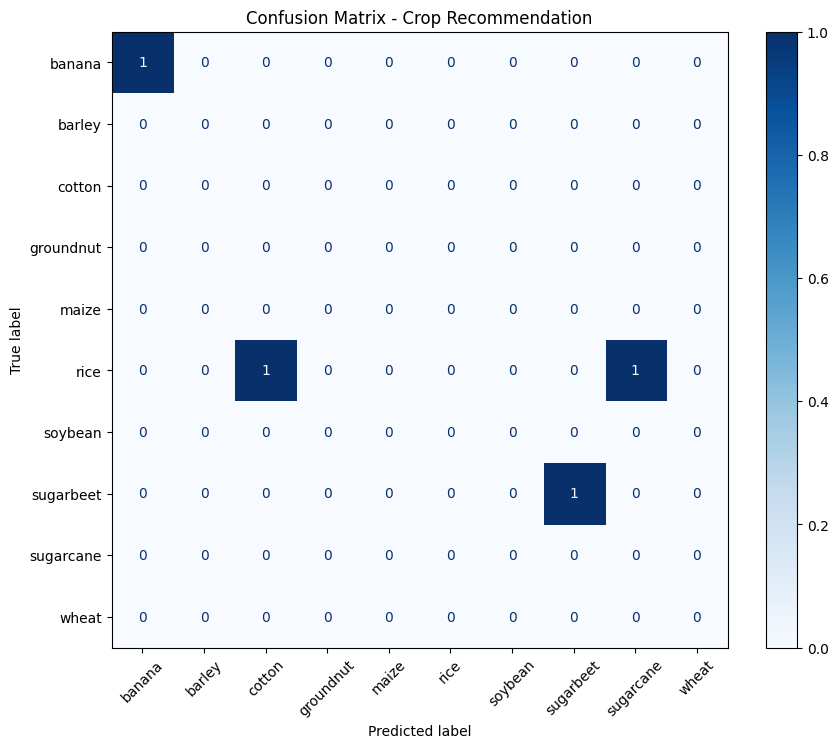

In [14]:
# Display the confusion matrix for crop recommendation model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_crop_test, y_crop_pred, labels=np.arange(len(le_crop.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_crop.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Crop Recommendation')
plt.show()

In [8]:
# Train RandomForestRegressor for yield prediction
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
 
reg_yield = RandomForestRegressor(n_estimators=100, random_state=42)
reg_yield.fit(X_yield_train, y_yield_train)
y_yield_pred = reg_yield.predict(X_yield_test)
r2 = r2_score(y_yield_test, y_yield_pred)
mse = mean_squared_error(y_yield_test, y_yield_pred)
print(f'Yield Prediction Model R² Score: {r2:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
 
# Save the trained model
joblib.dump(reg_yield, '../src/yield_prediction_model.joblib')

Yield Prediction Model R² Score: 0.63
Mean Squared Error: 1.06


['../src/yield_prediction_model.joblib']

## Next Steps and Deployment
- Integrate the trained models into the Streamlit app for user interaction.
- Use joblib to load models in the app and provide predictions based on user input.
- Continue to improve model performance and update datasets as needed.
- Document the workflow and results in the README.